In [1]:
import smFRET_functions as sm
from PIL import Image
import numpy as np
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import matplotlib.pyplot as plt
from normxcorr2 import normxcorr2
import statistics
import math


In [3]:
data = sm.read_tiff('PSD78/200703/encapPSD78.tif')

In [54]:
data.shape

(560, 512, 512)

In [5]:
firstred = 10
green = 500

In [6]:
greendata = data[firstred:firstred+green,:,:]
reddata = data[firstred+green:,:,:]
green_avg = np.mean(greendata, axis = 0).flatten()
green_d = np.mean(greendata[:,:,:256], axis = 0).flatten()
green_a = np.mean(greendata[:,:,256:], axis = 0).flatten()
red_avg = np.mean(reddata, axis = 0).flatten()
red_d = np.mean(reddata[:,:,:256], axis = 0).flatten()
red_a = np.mean(reddata[:,:,256:], axis = 0).flatten()

In [78]:
counts_g, bins_g = np.histogram(green_avg, bins=100)
bg_threshold_g = math.ceil(bins_g[(np.where(counts_g==np.max(counts_g))[0][0]+1)])
counts_r, bins_r = np.histogram(red_avg, bins=100)
bg_threshold_r = math.ceil(bins_r[(np.where(counts_r==np.max(counts_r))[0][0]+1)])
bg_threshold_g, bg_threshold_r


greenbg_d = statistics.median(green_d[np.where(green_d<bg_threshold_g)])
greenbg_a = statistics.median(green_a[np.where(green_a<bg_threshold_g)])
redbg_d = statistics.median(red_d[np.where(red_d<bg_threshold_r)])
redbg_a = statistics.median(red_a[np.where(red_a<bg_threshold_r)])
    

#bg-subtraction
r1_a = data[:firstred,:,256:512]-redbg_a
g_a = data[firstred:firstred+green,:,256:512]-greenbg_a
r2_a = data[firstred+green:,:,256:512]-redbg_a
r1_d = data[:firstred,:,0:256]-redbg_d
g_d = data[firstred:firstred+green,:,:256]-greenbg_d
r2_d = data[firstred+green:,:,:256]-redbg_d



In [74]:
greenbg_d.shape, greenbg_a.shape, redbg_d.shape, redbg_a.shape

((106230,), (127814,), (130725,), (125435,))

In [102]:
acceptor = np.vstack((r1_a, g_a, r2_a))
donor = np.vstack((r1_d, g_d, r2_d))
data = np.dstack((donor,acceptor))


In [104]:
data

array([[[-27.74, -16.74, -23.74, ..., -18.  , -33.  , -41.  ],
        [-14.74,  -5.74, -18.74, ..., -38.  , -37.  , -18.  ],
        [-11.74, -17.74,  -9.74, ...,   5.  ,  56.  , -12.  ],
        ...,
        [-15.74,  59.26,  -9.74, ..., -15.  , -28.  , -28.  ],
        [-12.74, -10.74, -13.74, ..., -29.  , -31.  , -25.  ],
        [-11.74, -14.74, -13.74, ..., -27.  , -26.  , -26.  ]],

       [[-17.74, -25.74, -22.74, ..., -23.  , -19.  , -41.  ],
        [-16.74, -20.74, -14.74, ...,  90.  , -44.  , -33.  ],
        [-12.74, -12.74, -26.74, ..., -44.  ,  11.  , -34.  ],
        ...,
        [-11.74,   1.26,  -8.74, ..., -34.  , -25.  , -35.  ],
        [-12.74, -11.74,  -9.74, ..., -34.  , -11.  , -32.  ],
        [-14.74, -10.74, -13.74, ..., -25.  , -33.  , -25.  ]],

       [[-13.74, -20.74, -13.74, ..., -33.  , -29.  , -41.  ],
        [-21.74, -19.74, -20.74, ..., -45.  , -38.  , -35.  ],
        [-19.74, -17.74, -18.74, ..., -30.  , -20.  , -31.  ],
        ...,
        [-12

In [141]:
def bg_avg(data):
    greendata = data[firstred:firstred+green,:,:]
    reddata = data[firstred+green:,:,:]
    green_avg = np.mean(greendata, axis = 0).flatten()
    green_d = np.mean(greendata[:,:,:256], axis = 0).flatten()
    green_a = np.mean(greendata[:,:,256:], axis = 0).flatten()
    red_avg = np.mean(reddata, axis = 0).flatten()
    red_d = np.mean(reddata[:,:,:256], axis = 0).flatten()
    red_a = np.mean(reddata[:,:,256:], axis = 0).flatten()
    
    counts_g, bins_g = np.histogram(green_avg, bins=100)
    bg_threshold_g= math.ceil(bins_g[(np.where(np.max(counts_g))[0]+1)])
    
    counts_r, bins_r = np.histogram(red_avg, bins=100)
    bg_threshold_r= math.ceil(bins_r[(np.where(np.max(counts_r))[0]+1)])
    
    greenbg = green_avg[np.where(green_avg<bg_threshold_g)]
    greenbg_d = green_d[np.where(green_d<bg_threshold_g)]
    greenbg_a = green_a[np.where(green_a<bg_threshold_g)]
    redbg = red_avg[np.where(red_avg<bg_threshold_r)]
    redbg_d = red_d[np.where(red_d<bg_threshold_r)]
    redbg_a = red_a[np.where(red_a<bg_threshold_r)]
    
    fig = plt.figure(figsize=(8,16))
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)
    ax1.hist(greenbg, bins=100, weights=np.ones(len(greenbg))/len(greenbg) , color='g', edgecolor='k')
    ax2.hist(greenbg_d, bins=100, weights=np.ones(len(greenbg_d))/len(greenbg_d) , color='g', edgecolor='k')
    ax3.hist(greenbg_a, bins=100, weights=np.ones(len(greenbg_a))/len(greenbg_a) , color='g', edgecolor='k')
    ax1.title.set_text('entire green frames averaged')
    ax2.title.set_text('green donor channel averaged')
    ax3.title.set_text('green acceptor channel averaged')
    
    fig = plt.figure(figsize=(8,16))
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)
    ax1.hist(redbg, bins=100, weights=np.ones(len(redbg))/len(redbg) , color='r', edgecolor='k')
    ax2.hist(redbg_d, bins=100, weights=np.ones(len(redbg_d))/len(redbg_d) , color='r', edgecolor='k')
    ax3.hist(redbg_a, bins=100, weights=np.ones(len(redbg_a))/len(redbg_a) , color='r', edgecolor='k')
    ax1.title.set_text('entire red frames averaged')
    ax2.title.set_text('red donor channel averaged')
    ax3.title.set_text('red acceptor channel averaged')    

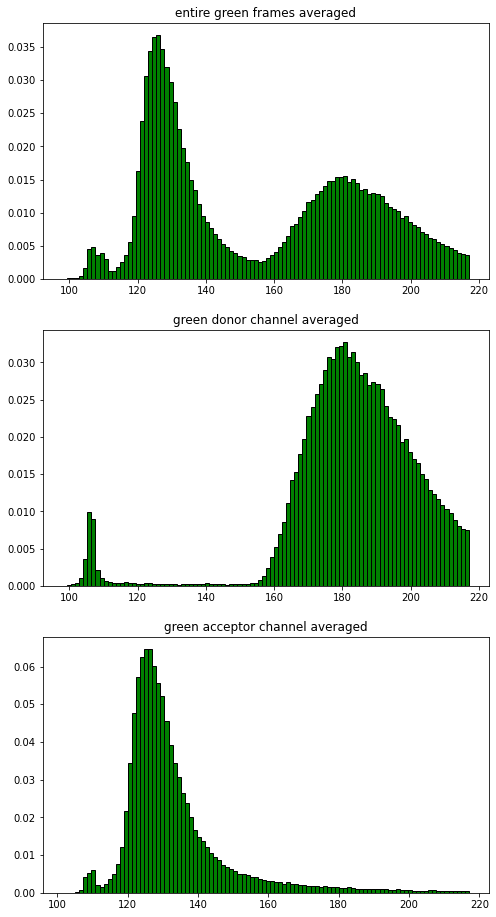

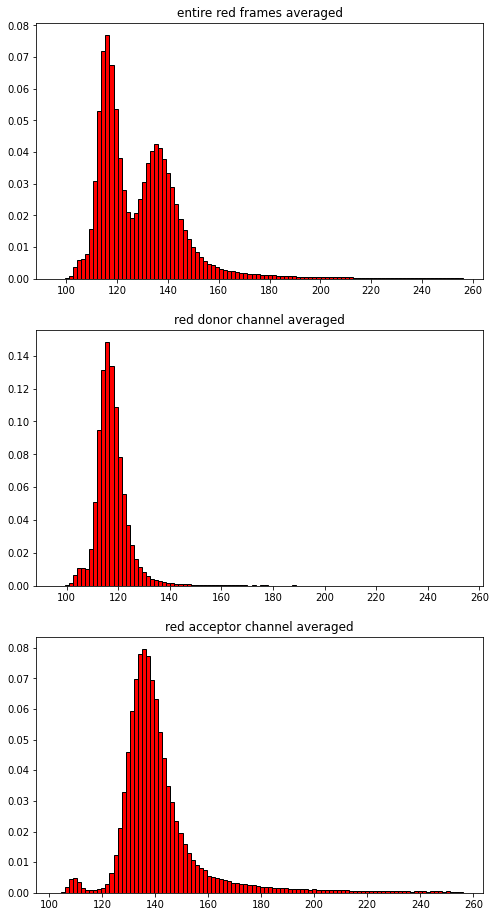

In [142]:
bg_avg(data)

In [101]:
234020/(512**2)

0.8927154541015625

(array([8.92715454e-01, 7.82508850e-02, 1.25350952e-02, 5.83648682e-03,
        3.15475464e-03, 2.13241577e-03, 1.39999390e-03, 9.68933105e-04,
        7.24792480e-04, 4.76837158e-04, 4.31060791e-04, 3.01361084e-04,
        2.44140625e-04, 2.21252441e-04, 9.15527344e-05, 1.02996826e-04,
        6.10351562e-05, 6.10351562e-05, 4.57763672e-05, 3.43322754e-05,
        2.28881836e-05, 2.67028809e-05, 3.43322754e-05, 3.05175781e-05,
        7.62939453e-06, 3.81469727e-06, 3.81469727e-06, 0.00000000e+00,
        1.52587891e-05, 7.62939453e-06, 7.62939453e-06, 3.81469727e-06,
        3.81469727e-06, 3.81469727e-06, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.62939453e-06, 0.00000000e+00, 0.00000000e+00,
        3.81469727e-06, 3.81469727e-06, 0.00000000e+00, 3.81469727e-06,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.81469727e-06, 0.00000000e+00, 0.00000000e+00,
        3.81469727e-06, 0.00000000e+00, 0.00000000e+00, 0.000000

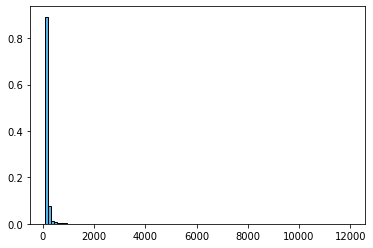

In [73]:
avg = plt.hist(green_avg, bins=100, weights=np.ones(len(green_avg))/len(green_avg) , color='#56B4E9', edgecolor='k')
statistics.median(green_avg)
avg

148.728

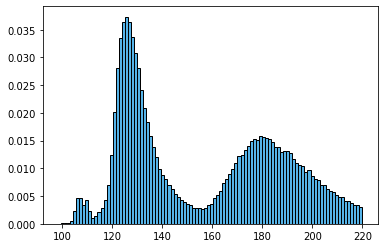

In [74]:
greenbg = green_avg[np.where(green_avg<220)]
greenbg_d = green_d[np.where(green_d<220)]
greenbg_a = green_a[np.where(green_a<220)]
statistics.median(greenbg)
statistics.median(greenbg_d)
statistics.median(greenbg_a)

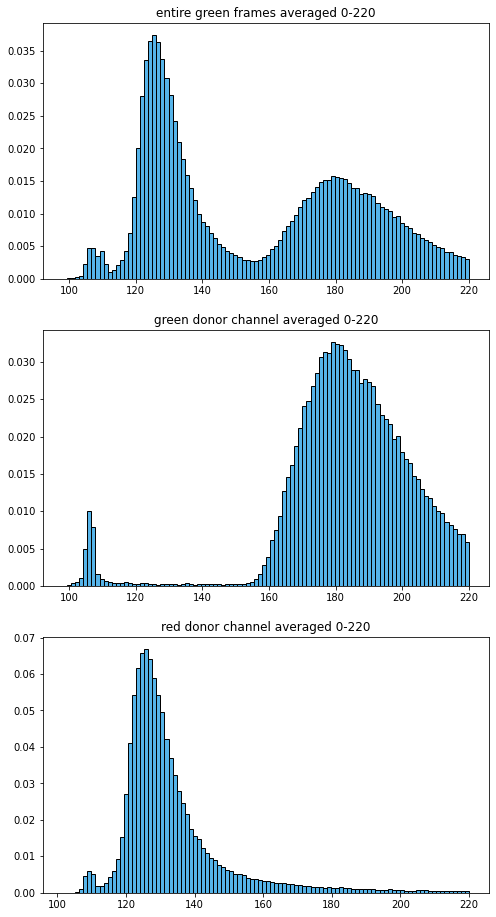

In [94]:
fig = plt.figure(figsize=(8,16))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.hist(greenbg, bins=100, weights=np.ones(len(greenbg))/len(greenbg) , color='#56B4E9', edgecolor='k')
ax2.hist(greenbg_d, bins=100, weights=np.ones(len(greenbg_d))/len(greenbg_d) , color='#56B4E9', edgecolor='k')
ax3.hist(greenbg_a, bins=100, weights=np.ones(len(greenbg_a))/len(greenbg_a) , color='#56B4E9', edgecolor='k')
ax1.title.set_text('entire green frames averaged 0-220')
ax2.title.set_text('green donor channel averaged 0-220')
ax3.title.set_text('red donor channel averaged 0-220')
plt.show()

In [147]:
(data-200).shape

(560, 512, 512)